In [1]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn import metrics

import ppscore as pps
import warnings
warnings.filterwarnings('ignore')

# define random state for separating training and test set
rs=123

/Users/candice/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# read data
prod = pd.read_excel(r'/Users/candice/Desktop/Dissertation/project2/Data.xlsx',sheet_name='Product')
print(prod.shape)
prod.head()

(23437, 23)


,product_id,barcode,brand,name,size,size_unit,product_category_id,product_type_id,container_id,material_1,...,material_3,packaging_part_3,material_4,packaging_part_4,material_5,packaging_part_5,material_6,packaging_part_6,material_7,packaging_part_7
0,9306,50097265,Axe,Roll On Deoterant: Africa,NaN,NaN,beauty_cosmetics,legacy,applicator_plastic,pm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9307,25375510,Health Essentials,Ibuprofen 200mg Coated Tablets,NaN,NaN,healthcare,legacy,box_paper,cc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9308,838623305246,Between The Lines,Disposable Masks,NaN,NaN,healthcare,legacy,pouch_plastic,pm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9309,25375527,Health Essentials,Paracetamol 500mg Tablets,NaN,NaN,healthcare,legacy,box_paper,cc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9310,813481022320,Chagrin Valley Soap & Salve,Lavender Rosemary Lotion Candle,NaN,NaN,household,legacy,tin_metal,ma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# check data type and missing values
# roughly complete data
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23437 entries, 0 to 23436
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           23437 non-null  int64  
 1   barcode              23437 non-null  int64  
 2   brand                23437 non-null  object 
 3   name                 23437 non-null  object 
 4   size                 21822 non-null  float64
 5   size_unit            22205 non-null  object 
 6   product_category_id  23437 non-null  object 
 7   product_type_id      23437 non-null  object 
 8   container_id         23437 non-null  object 
 9   material_1           23437 non-null  object 
 10  packaging_part_1     23437 non-null  object 
 11  material_2           13877 non-null  object 
 12  packaging_part_2     13877 non-null  object 
 13  material_3           6419 non-null   object 
 14  packaging_part_3     6419 non-null   object 
 15  material_4           874 non-null   

In [4]:
# find the frequency distribution of 'product category'
prod['product_category_id'].value_counts()

food                 14536
drink                 5601
personal_hygiene       815
household              747
textiles               476
cleaning_products      298
beauty_cosmetics       195
healthcare             170
toys                   151
pet_supplies           133
Food                   116
diy_industrial          64
other                   48
Personal_hygiene        31
electronics             19
Drink                   12
hazardous               10
media                    8
Healthcare               4
Toys                     2
Other                    1
Name: product_category_id, dtype: int64

In [5]:
# unify upper and lower letters in factor level
prod['product_category_id'] = prod['product_category_id'].str.lower()
prod['product_category_id'].value_counts()

food                 14652
drink                 5613
personal_hygiene       846
household              747
textiles               476
cleaning_products      298
beauty_cosmetics       195
healthcare             174
toys                   153
pet_supplies           133
diy_industrial          64
other                   49
electronics             19
hazardous               10
media                    8
Name: product_category_id, dtype: int64

In [6]:
# frequency distribution of 'size unit'
prod['size_unit'].value_counts()

g        12805
ml        5076
count     2021
cl         606
oz         506
L          478
kg         229
pcs        186
fl oz      163
lb          42
l           27
fl_oz       16
pt          15
m           10
other        5
mg           5
qt           4
gal          3
none         2
ft           2
mL           1
yrd          1
cm           1
in           1
Name: size_unit, dtype: int64

In [7]:
# unify upper and lower letters
prod['size_unit'] = prod['size_unit'].str.lower()
# unify same class label
prod.loc[prod["size_unit"] == "fl oz", "size_unit"] = "fl_oz"
prod['size_unit'].value_counts()

g        12805
ml        5077
count     2021
cl         606
oz         506
l          505
kg         229
pcs        186
fl_oz      179
lb          42
pt          15
m           10
other        5
mg           5
qt           4
gal          3
none         2
ft           2
in           1
yrd          1
cm           1
Name: size_unit, dtype: int64

In [8]:
# we want a complete data set
# however, there are products without size unit and size records
# drop observations with missing size and size unit records
prod_na = prod.dropna(subset=["size_unit","size"],inplace=False)
print(prod.shape,prod_na.shape)
prod_na.head()


(23437, 23) (21774, 23)


,product_id,barcode,brand,name,size,size_unit,product_category_id,product_type_id,container_id,material_1,...,material_3,packaging_part_3,material_4,packaging_part_4,material_5,packaging_part_5,material_6,packaging_part_6,material_7,packaging_part_7
6,9312,5011451103931,Simple,Moisturiser,125.0,ml,beauty_cosmetics,legacy,box_paper,cc,...,pm,lid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9313,5025970023243,Nivea Men,Shaving Gel,200.0,ml,beauty_cosmetics,legacy,aerosol_metal,ma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,9316,50398621,VO5,Styling Wax,75.0,ml,beauty_cosmetics,legacy,jar_plastic,p5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,9318,79656007046,Banana Boat,Sport Body & Scalp,177.0,ml,beauty_cosmetics,legacy,spray-bottle_plastic,p1,...,p5,lid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,9319,5000209888527,Colgate,Peroxyl Mouthwash,300.0,ml,personal_hygiene,legacy,jar_plastic,p1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# convert all object-typed features to categorical for easy modelling
cols = prod_na.columns[prod_na.dtypes == "object"].tolist()
for col in cols:
    prod_na[col] = prod_na[col].astype("category")
    
prod_na.dtypes

product_id                int64
barcode                   int64
brand                  category
name                   category
size                    float64
size_unit              category
product_category_id    category
product_type_id        category
container_id           category
material_1             category
packaging_part_1       category
material_2             category
packaging_part_2       category
material_3             category
packaging_part_3       category
material_4             category
packaging_part_4       category
material_5             category
packaging_part_5       category
material_6             category
packaging_part_6       category
material_7              float64
packaging_part_7        float64
dtype: object

In [10]:
# we will not use product_id, barcode, brand, and name in modelling
prod_mod = prod_na.iloc[:,4:]
print(prod_mod.shape)

# treat 'legacy' not as a true type (i.e. 'legacy' means missing value in product type)
# for easy modelling, only use product data whose product type is not 'legacy'
prod_legacy = prod_mod.loc[prod['product_type_id'] == 'legacy']
prod_complete = prod_mod.loc[prod['product_type_id'] != 'legacy']

# reset index of sorted dataframe
prod_legacy = prod_legacy.reset_index(drop=True)
prod_complete = prod_complete.reset_index(drop=True)

print(prod_legacy.shape, prod_complete.shape)
prod_complete.head()

(21774, 19)
(3118, 19) (18656, 19)


,size,size_unit,product_category_id,product_type_id,container_id,material_1,packaging_part_1,material_2,packaging_part_2,material_3,packaging_part_3,material_4,packaging_part_4,material_5,packaging_part_5,material_6,packaging_part_6,material_7,packaging_part_7
0,0.384456,l,personal_hygiene,skin_care,pump-bottle_plastic,p2,btl,om,pmp,p7,lbl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.236000,l,drink,milk,gable-top_other,cl,gtc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.750000,l,drink,alcoholic,bottle_glass,go,btl,bk,crk,p5,lbl,cc,box,NaN,NaN,NaN,NaN,NaN,NaN
3,0.500000,l,drink,juice,bottle_plastic,p1,btl,p2,cap,pm,wrp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.463000,l,food,frozen_refrigerated,pot_paper,cl,pot,cl,lid,p7,flm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


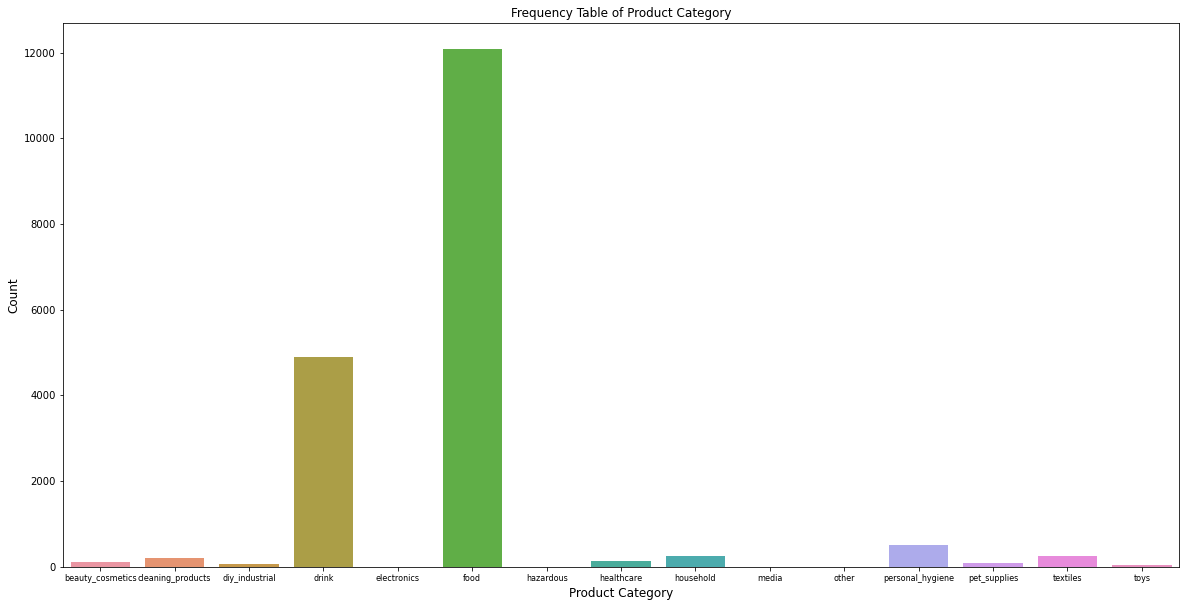

In [11]:
# visulise category
plt.figure(figsize=(20,10)) 
plt.tick_params(axis='x', labelsize=8)
sns.countplot(x='product_category_id',data=prod_complete)
plt.xlabel('Product Category',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Frequency Table of Product Category',fontsize=12)
plt.show()

In [12]:
# number of categorical levels in category
prod_complete['product_category_id'].value_counts().count()

15

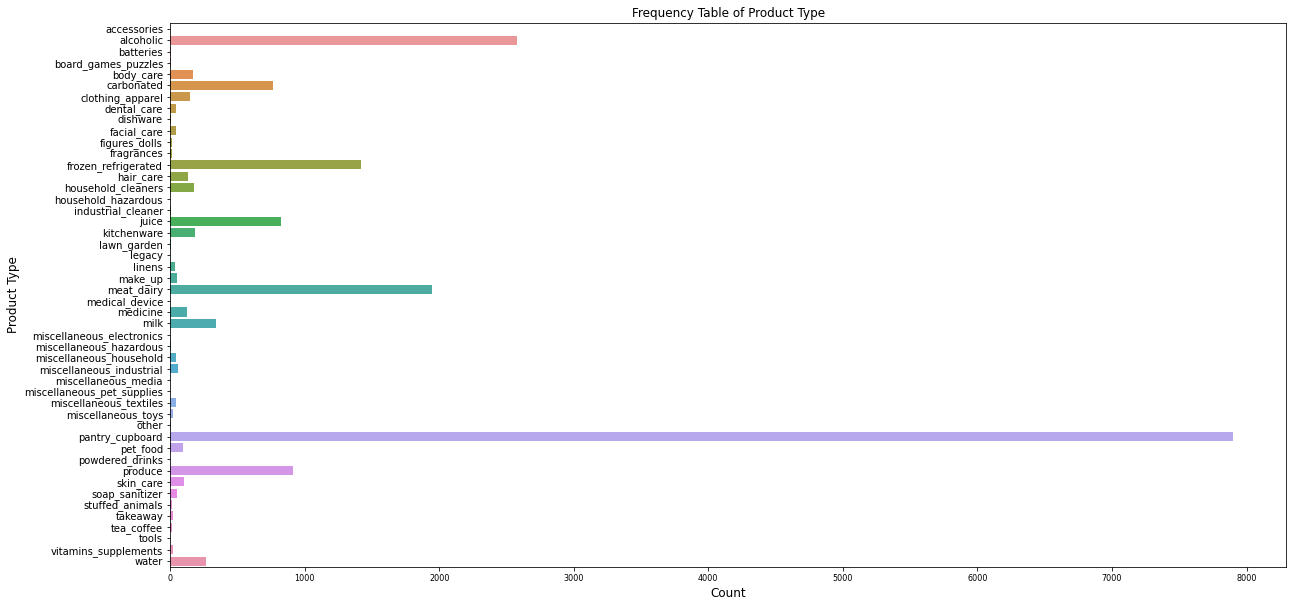

In [13]:
# visulise type
plt.figure(figsize=(20,10)) 
plt.tick_params(axis='x', labelsize=8)
sns.countplot(y='product_type_id',data=prod_complete)
plt.xlabel('Count',fontsize=12)
plt.ylabel('Product Type',fontsize=12)
plt.title('Frequency Table of Product Type',fontsize=12)
plt.show()

In [14]:
# number of categorical levels in type
prod_complete['product_type_id'].value_counts().count()

48

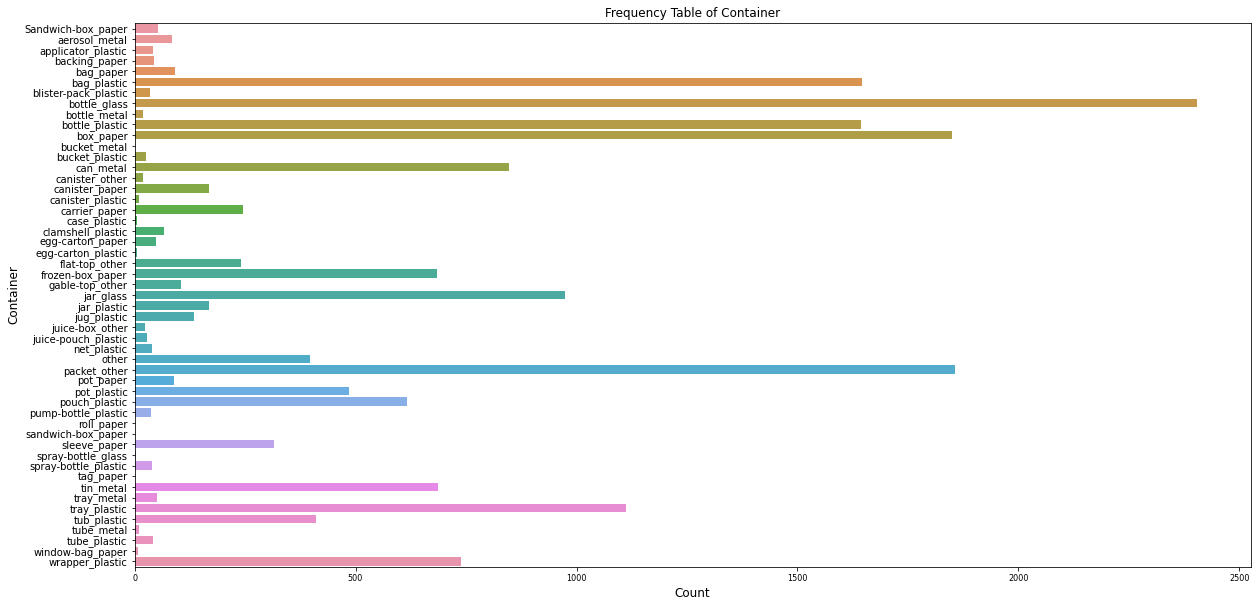

In [15]:
# visulise container
plt.figure(figsize=(20,10)) 
plt.tick_params(axis='x', labelsize=8)
sns.countplot(y='container_id',data=prod_complete)
plt.xlabel('Count',fontsize=12)
plt.ylabel('Container',fontsize=12)
plt.title('Frequency Table of Container',fontsize=12)
plt.show()

In [16]:
# number of categorical levels in container
prod_complete['container_id'].value_counts().count()

51

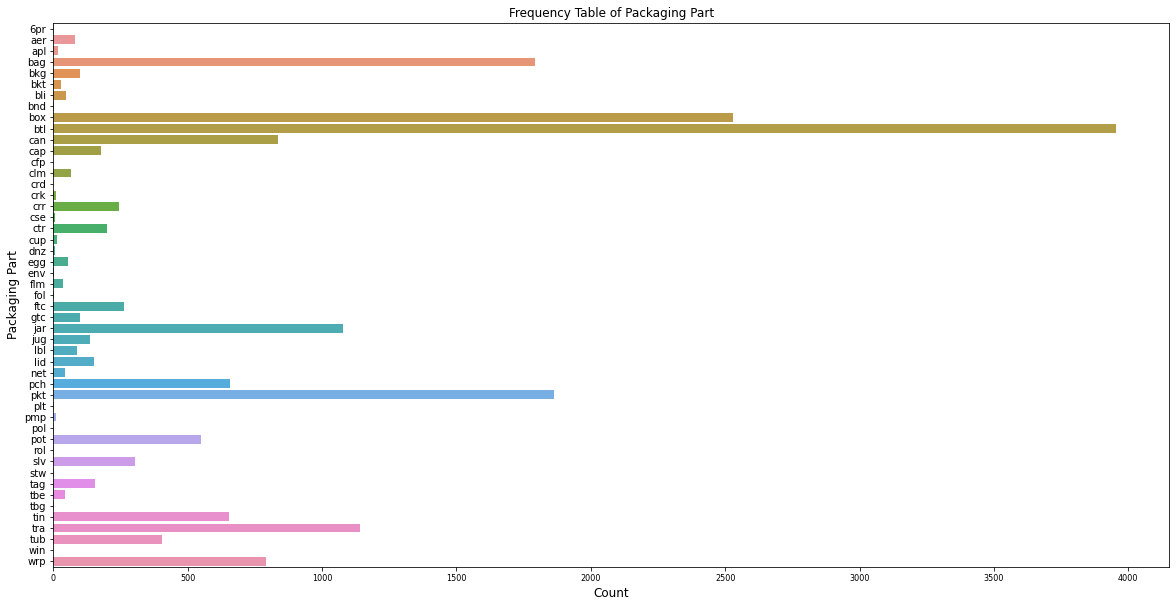

In [17]:
# visulise packaging part 1
plt.figure(figsize=(20,10)) 
plt.tick_params(axis='x', labelsize=8)
sns.countplot(y='packaging_part_1',data=prod_complete)
plt.xlabel('Count',fontsize=12)
plt.ylabel('Packaging Part',fontsize=12)
plt.title('Frequency Table of Packaging Part',fontsize=12)
plt.show()

In [18]:
# number of categorical levels in packaging part
prod_complete['packaging_part_1'].value_counts().count()

49

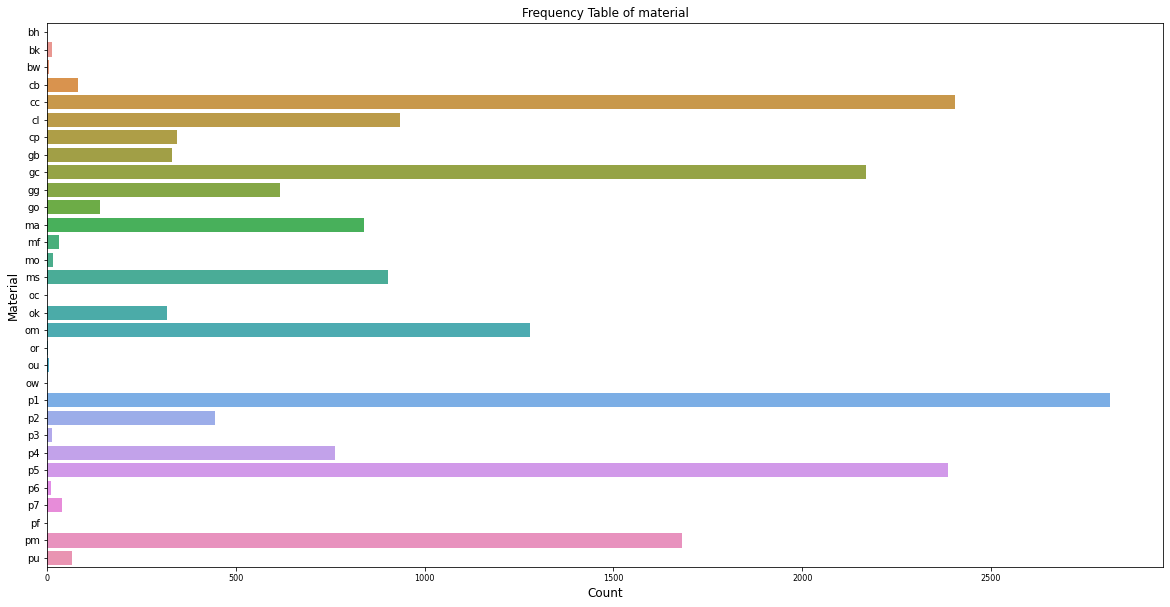

In [19]:
# visulise material 1
plt.figure(figsize=(20,10)) 
plt.tick_params(axis='x', labelsize=8)
sns.countplot(y='material_1',data=prod_complete)
plt.xlabel('Count',fontsize=12)
plt.ylabel('Material',fontsize=12)
plt.title('Frequency Table of material',fontsize=12)
plt.show()

In [20]:
# number of categorical levels in material
prod_complete['material_1'].value_counts().count()

31

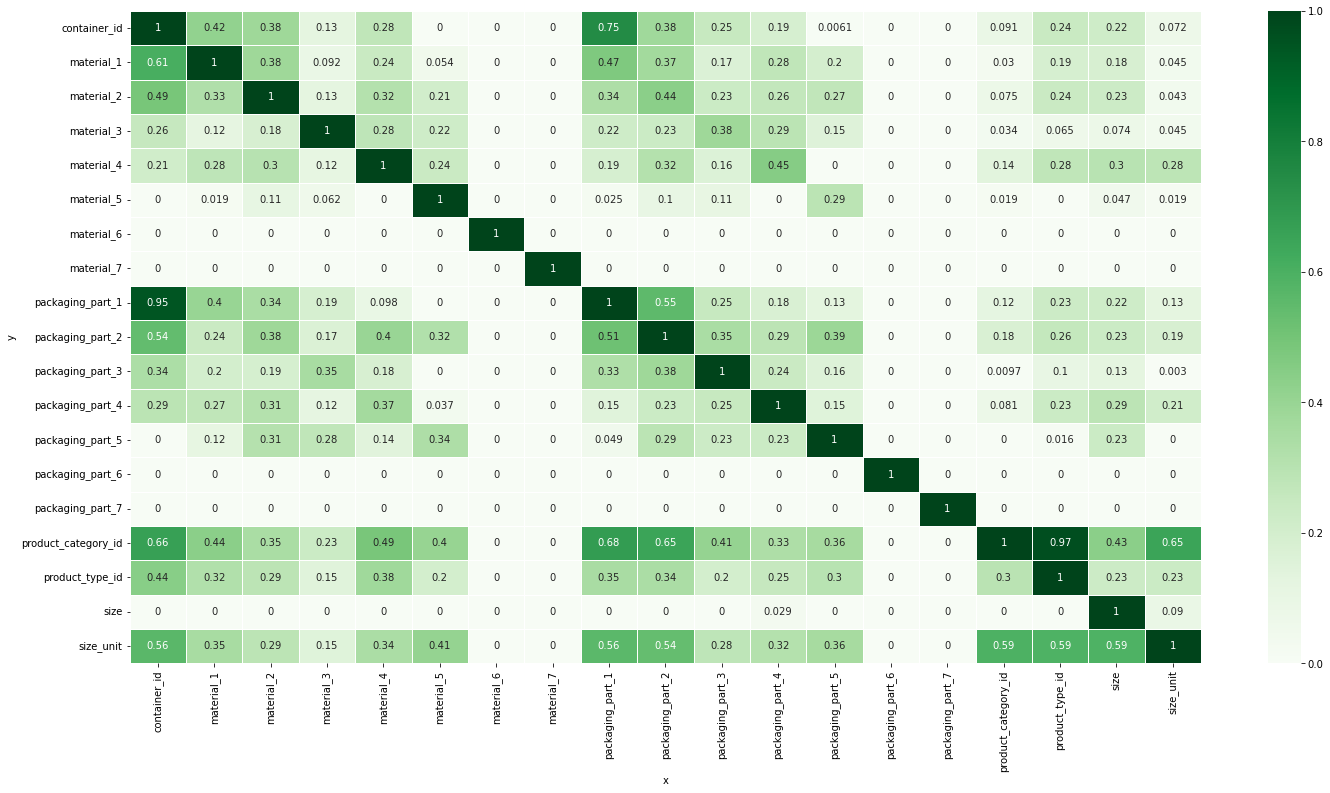

In [21]:
# check relationship between features
# Calculate the Predict Power Score matrix
mat = pps.matrix(prod_complete)

mat = mat[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

# Plot the Predict Power Score
plt.figure(figsize = (24, 12))
sns.heatmap(mat, vmin=0, vmax=1, cmap="Greens", linewidths=0.5, annot=True)
plt.show()

In [22]:
# according to the pps score
# decide to drop size, packaging part/material 6&7 as they seem useless for modelling
prod_complete = prod_complete.drop(['size','material_6','material_7','packaging_part_6','packaging_part_7'],axis=1)
print(prod_complete.shape)
prod_complete.head()

(18656, 14)


,size_unit,product_category_id,product_type_id,container_id,material_1,packaging_part_1,material_2,packaging_part_2,material_3,packaging_part_3,material_4,packaging_part_4,material_5,packaging_part_5
0,l,personal_hygiene,skin_care,pump-bottle_plastic,p2,btl,om,pmp,p7,lbl,NaN,NaN,NaN,NaN
1,l,drink,milk,gable-top_other,cl,gtc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,l,drink,alcoholic,bottle_glass,go,btl,bk,crk,p5,lbl,cc,box,NaN,NaN
3,l,drink,juice,bottle_plastic,p1,btl,p2,cap,pm,wrp,NaN,NaN,NaN,NaN
4,l,food,frozen_refrigerated,pot_paper,cl,pot,cl,lid,p7,flm,NaN,NaN,NaN,NaN


In [23]:
# predict category with feature selection
prod_cat = prod_complete.copy()
prod_cat = prod_cat[['size_unit','product_category_id','product_type_id']]

# encoding categorical levels of independent features
dummy_vars = ['product_type_id','size_unit']

# model matrix and response vector
X_cat = prod_cat.drop('product_category_id',axis=1) # Independet variables
for col in dummy_vars:
    X_cat[col] = X_cat[col].cat.codes

y_cat = prod_cat['product_category_id'] # dependent variable

# split training and test data
X_cattrain, X_cattest, y_cattrain, y_cattest = train_test_split(X_cat, y_cat, random_state=rs, test_size=0.30)

X_cat.head()

# fit model
# be careful that each class in the variable are imbalanced
mul_lr_cat = LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight='balanced').fit(X_cattrain,y_cattrain)
print("Accuracy score for training data:", metrics.accuracy_score(y_cattrain,mul_lr_cat.predict(X_cattrain)))
print("Accuracy score for test data:", metrics.accuracy_score(y_cattest,mul_lr_cat.predict(X_cattest)))

Accuracy score for training data: 0.1529213569186002
Accuracy score for test data: 0.14936573164195105


In [24]:
# predict category without feature selection
prod_cat = prod_complete.copy()

# encoding categorical levels of independent features
dummy_vars = prod_cat.columns.tolist()
dummy_vars.remove('product_category_id')

# model matrix and response vector
X_cat = prod_cat.drop('product_category_id',axis=1) # Independet variables
for col in dummy_vars:
    X_cat[col] = X_cat[col].cat.codes

y_cat = prod_cat['product_category_id'] # dependent variable

# split training and test data
X_cattrain, X_cattest, y_cattrain, y_cattest = train_test_split(X_cat, y_cat, random_state=rs, test_size=0.30)

X_cat.head()

# fit model
mul_lr_cat = LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight='balanced').fit(X_cattrain,y_cattrain)
print("Accuracy score for training data:", metrics.accuracy_score(y_cattrain,mul_lr_cat.predict(X_cattrain)))
print("Accuracy score for test data:", metrics.accuracy_score(y_cattest,mul_lr_cat.predict(X_cattest)))

Accuracy score for training data: 0.3454322689333027
Accuracy score for test data: 0.34393425049133464


In [25]:
# predict product type with feature selection
prod_type = prod_complete.copy()
prod_type = prod_type.drop(['material_3','packaging_part_3','material_5','packaging_part_5'],axis=1)

# encoding categorical levels of independent features
dummy_vars = prod_type.columns.tolist()
dummy_vars.remove('product_type_id')

# model matrix and response vector
X_type = prod_type.drop('product_type_id',axis=1) # Independet variables
for col in dummy_vars:
    X_type[col] = X_type[col].cat.codes

y_type = prod_type['product_type_id'] # dependent variable

# split training and test data
X_typetrain, X_typetest, y_typetrain, y_typetest = train_test_split(X_type, y_type, random_state=rs, test_size=0.30)

# fit model
mul_lr_type = LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight='balanced').fit(X_typetrain,y_typetrain)
print("Accuracy score for training data:", metrics.accuracy_score(y_typetrain,mul_lr_type.predict(X_typetrain)))
print("Accuracy score for test data:", metrics.accuracy_score(y_typetest,mul_lr_type.predict(X_typetest)))

Accuracy score for training data: 0.2505551726778467
Accuracy score for test data: 0.25906735751295334


In [26]:
# predict product type without feature selection
prod_type = prod_complete.copy()

# encoding categorical levels of independent features
dummy_vars = prod_type.columns.tolist()
dummy_vars.remove('product_type_id')

# model matrix and response vector
X_type = prod_type.drop('product_type_id',axis=1) # Independet variables
for col in dummy_vars:
    X_type[col] = X_type[col].cat.codes

y_type = prod_type['product_type_id'] # dependent variable

# split training and test data
X_typetrain, X_typetest, y_typetrain, y_typetest = train_test_split(X_type, y_type, random_state=rs, test_size=0.30)

# fit model
mul_lr_type = LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight='balanced').fit(X_typetrain,y_typetrain)
print("Accuracy score for training data", metrics.accuracy_score(y_typetrain,mul_lr_type.predict(X_typetrain)))
print("Accuracy score for test data", metrics.accuracy_score(y_typetest,mul_lr_type.predict(X_typetest)))

Accuracy score for training data 0.30622559154606016
Accuracy score for test data 0.31373950330534217


In [27]:
# predict container with feature selection
prod_con = prod_complete.copy()
prod_con = prod_con.iloc[:,0:7] # size unit, category, container, part/material 1&2

# encoding categorical levels of independent features
dummy_vars = prod_con.columns.tolist()
dummy_vars.remove('container_id')

# model matrix and response vector
X_con = prod_con.drop('container_id',axis=1) # Independet variables
for col in dummy_vars:
    X_con[col] = X_con[col].cat.codes

y_con = prod_con['container_id'] # dependent variable

# split training and test data
X_contrain, X_contest, y_contrain, y_contest = train_test_split(X_con, y_con, random_state=rs, test_size=0.30)

# fit model
mul_lr_con = LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight='balanced').fit(X_contrain,y_contrain)
print("Accuracy score for training data:", metrics.accuracy_score(y_contrain,mul_lr_con.predict(X_contrain)))
print("Accuracy score for test data:", metrics.accuracy_score(y_contest,mul_lr_con.predict(X_contest)))


Accuracy score for training data: 0.6417030400490084
Accuracy score for test data: 0.646060389494372


In [28]:
# predict container without feature selection
prod_con = prod_complete.copy()

# encoding categorical levels of independent features
dummy_vars = prod_con.columns.tolist()
dummy_vars.remove('container_id')

# model matrix and response vector
X_con = prod_con.drop('container_id',axis=1) # Independet variables
for col in dummy_vars:
    X_con[col] = X_con[col].cat.codes

y_con = prod_con['container_id'] # dependent variable

# split training and test data
X_contrain, X_contest, y_contrain, y_contest = train_test_split(X_con, y_con, random_state=rs, test_size=0.30)

# fit model
mul_lr_con = LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight='balanced').fit(X_contrain,y_contrain)
print("Accuracy score for training data:", metrics.accuracy_score(y_contrain,mul_lr_con.predict(X_contrain)))
print("Accuracy score for test data:", metrics.accuracy_score(y_contest,mul_lr_con.predict(X_contest)))

Accuracy score for training data: 0.6907113867830615
Accuracy score for test data: 0.6916205109880293


In [29]:
# separate all packaging parts and material for easy constructing dependent vectors in further modelling
part = prod_complete[['packaging_part_1','packaging_part_2','packaging_part_3','packaging_part_4','packaging_part_5']]
material = prod_complete[['material_1','material_2','material_3','material_4','material_5']]

In [30]:
# predict packaging parts with feature selection
prod_part = prod_complete.copy()

# assume materials are not useful in predicting packaging parts
dummy_vars = part.append(material)
X_part = prod_part.drop(dummy_vars.columns.to_list(),axis=1)
for col in X_part.columns.tolist():
    X_part[col] = X_part[col].cat.codes

# nultiple output classifier does not accept NaN
y_part = part.copy()
for col in y_part.columns.tolist():
    y_part[col] = y_part[col].cat.codes

# split training and test data
X_parttrain, X_parttest, y_parttrain, y_parttest = train_test_split(X_part, y_part, random_state=rs, test_size=0.30)

# output 5 packaging parts simultaneously
mul_lr_part = MultiOutputClassifier(LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight='balanced')).fit(X_parttrain,y_parttrain)

# predict class labels of packaging parts
y_partpred_train = mul_lr_part.predict(X_parttrain)
y_partpred_test = mul_lr_part.predict(X_parttest)

# build dataframe
y_partpred_train = pd.DataFrame(y_partpred_train,columns=['packaging_part_1_pred','packaging_part_2_pred',
                                              'packaging_part_3_pred','packaging_part_4_pred',
                                              'packaging_part_5_pred'])
y_partpred_test = pd.DataFrame(y_partpred_test,columns=['packaging_part_1_pred','packaging_part_2_pred',
                                              'packaging_part_3_pred','packaging_part_4_pred',
                                              'packaging_part_5_pred'])

# reindex training and test sets for dependent variables to avoid mess up
y_parttrain = y_parttrain.reset_index(drop=True)                                              
y_parttest = y_parttest.reset_index(drop=True)  

# combine the true label and predicted label of packaging parts in order to calculate accuracy score
y_partmerge_train = pd.concat([y_parttrain,y_partpred_train],axis=1)
y_partmerge_test = pd.concat([y_parttest,y_partpred_test],axis=1)

print("Accuracy score for training part 1:", metrics.accuracy_score(y_partmerge_train['packaging_part_1'],y_partmerge_train['packaging_part_1_pred']))
print("Accuracy score for test part 1:", metrics.accuracy_score(y_partmerge_test['packaging_part_1'],y_partmerge_test['packaging_part_1_pred']))

print("Accuracy score for training part 2:", metrics.accuracy_score(y_partmerge_train['packaging_part_2'],y_partmerge_train['packaging_part_2_pred']))
print("Accuracy score for test part 2:", metrics.accuracy_score(y_partmerge_test['packaging_part_2'],y_partmerge_test['packaging_part_2_pred']))

print("Accuracy score for training part 3:", metrics.accuracy_score(y_partmerge_train['packaging_part_3'],y_partmerge_train['packaging_part_3_pred']))
print("Accuracy score for test part 3:", metrics.accuracy_score(y_partmerge_test['packaging_part_3'],y_partmerge_test['packaging_part_3_pred']))

print("Accuracy score for training part 4:", metrics.accuracy_score(y_partmerge_train['packaging_part_4'],y_partmerge_train['packaging_part_4_pred']))
print("Accuracy score for test part 4:", metrics.accuracy_score(y_partmerge_test['packaging_part_4'],y_partmerge_test['packaging_part_4_pred']))

print("Accuracy score for training part 5:", metrics.accuracy_score(y_partmerge_train['packaging_part_5'],y_partmerge_train['packaging_part_5_pred']))
print("Accuracy score for test part 5:", metrics.accuracy_score(y_partmerge_test['packaging_part_5'],y_partmerge_test['packaging_part_5_pred']))

Accuracy score for training part 1: 0.4047017382647982
Accuracy score for test part 1: 0.4025370734321958
Accuracy score for training part 2: 0.07994486560992418
Accuracy score for test part 2: 0.07468286582097552
Accuracy score for training part 3: 0.026341986369553566
Accuracy score for test part 3: 0.02179739145971056
Accuracy score for training part 4: 0.004135079255685734
Accuracy score for test part 4: 0.0032160085760228694
Accuracy score for training part 5: 0.2724557776246267
Accuracy score for test part 5: 0.25942469179917815


In [31]:
# predict parts without feature selection
prod_part = prod_complete.copy()

X_part = prod_part.drop(part.columns.tolist(),axis=1)
for col in X_part.columns.tolist():
    X_part[col] = X_part[col].cat.codes

# multiple output classifier does not accept NaN
y_part = part.copy()
for col in y_part.columns.tolist():
    y_part[col] = y_part[col].cat.codes

# split training and test data
X_parttrain, X_parttest, y_parttrain, y_parttest = train_test_split(X_part, y_part, random_state=rs, test_size=0.30)

mul_lr_part = MultiOutputClassifier(LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight='balanced')).fit(X_parttrain,y_parttrain)
y_partpred_train = mul_lr_part.predict(X_parttrain)
y_partpred_test = mul_lr_part.predict(X_parttest)

y_partpred_train = pd.DataFrame(y_partpred_train,columns=['packaging_part_1_pred','packaging_part_2_pred',
                                              'packaging_part_3_pred','packaging_part_4_pred',
                                              'packaging_part_5_pred'])
y_partpred_test = pd.DataFrame(y_partpred_test,columns=['packaging_part_1_pred','packaging_part_2_pred',
                                              'packaging_part_3_pred','packaging_part_4_pred',
                                              'packaging_part_5_pred'])

y_parttrain = y_parttrain.reset_index(drop=True)                                              
y_parttest = y_parttest.reset_index(drop=True)  

y_partmerge_train = pd.concat([y_parttrain,y_partpred_train],axis=1)
y_partmerge_test = pd.concat([y_parttest,y_partpred_test],axis=1)

print("Accuracy score for training part 1:", metrics.accuracy_score(y_partmerge_train['packaging_part_1'],y_partmerge_train['packaging_part_1_pred']))
print("Accuracy score for test part 1:", metrics.accuracy_score(y_partmerge_test['packaging_part_1'],y_partmerge_test['packaging_part_1_pred']))

print("Accuracy score for training part 2:", metrics.accuracy_score(y_partmerge_train['packaging_part_2'],y_partmerge_train['packaging_part_2_pred']))
print("Accuracy score for test part 2:", metrics.accuracy_score(y_partmerge_test['packaging_part_2'],y_partmerge_test['packaging_part_2_pred']))

print("Accuracy score for training part 3:", metrics.accuracy_score(y_partmerge_train['packaging_part_3'],y_partmerge_train['packaging_part_3_pred']))
print("Accuracy score for test part 3:", metrics.accuracy_score(y_partmerge_test['packaging_part_3'],y_partmerge_test['packaging_part_3_pred']))

print("Accuracy score for training part 4:", metrics.accuracy_score(y_partmerge_train['packaging_part_4'],y_partmerge_train['packaging_part_4_pred']))
print("Accuracy score for test part 4:", metrics.accuracy_score(y_partmerge_test['packaging_part_4'],y_partmerge_test['packaging_part_4_pred']))

print("Accuracy score for training part 5:", metrics.accuracy_score(y_partmerge_train['packaging_part_5'],y_partmerge_train['packaging_part_5_pred']))
print("Accuracy score for test part 5:", metrics.accuracy_score(y_partmerge_test['packaging_part_5'],y_partmerge_test['packaging_part_5_pred']))

Accuracy score for training part 1: 0.5642851673175587
Accuracy score for test part 1: 0.5626228336608897
Accuracy score for training part 2: 0.552951987135309
Accuracy score for test part 2: 0.5515454707879222
Accuracy score for training part 3: 0.7614671873803507
Accuracy score for test part 3: 0.7620153653743077
Accuracy score for training part 4: 0.9530591928937897
Accuracy score for test part 4: 0.9506878685009826
Accuracy score for training part 5: 0.9985450647063328
Accuracy score for test part 5: 0.9974986599964266


In [32]:
# we do not do any feature selection for materials according to pps matrix
prod_mat = prod_complete.copy()

X_mat = prod_mat.drop(material.columns.tolist(),axis=1)
for col in X_mat.columns.tolist():
    X_mat[col] = X_mat[col].cat.codes

# multiple output classifier does not accept NaN
y_mat = material.copy()
for col in y_mat.columns.tolist():
    y_mat[col] = y_mat[col].cat.codes

# split training and test data
X_mattrain, X_mattest, y_mattrain, y_mattest = train_test_split(X_mat, y_mat, random_state=rs, test_size=0.30)

# fit model
mul_lr_mat = MultiOutputClassifier(LogisticRegression(multi_class='multinomial',solver='lbfgs',class_weight='balanced')).fit(X_mattrain,y_mattrain)

y_matpred_train = mul_lr_mat.predict(X_mattrain)
y_matpred_test = mul_lr_mat.predict(X_mattest)

y_matpred_train = pd.DataFrame(y_matpred_train,columns=['material_1_pred','material_2_pred',
                                              'material_3_pred','material_4_pred',
                                              'material_5_pred'])
y_matpred_test = pd.DataFrame(y_matpred_test,columns=['material_1_pred','material_2_pred',
                                              'material_3_pred','material_4_pred',
                                              'material_5_pred'])

y_mattrain = y_mattrain.reset_index(drop=True)                                              
y_mattest = y_mattest.reset_index(drop=True)  

# combine true label and predicted label for materials together
y_matmerge_train = pd.concat([y_mattrain,y_matpred_train],axis=1)
y_matmerge_test = pd.concat([y_mattest,y_matpred_test],axis=1)

print("Accuracy score for training material 1:", metrics.accuracy_score(y_matmerge_train['material_1'],y_matmerge_train['material_1_pred']))
print("Accuracy score for test material 1:", metrics.accuracy_score(y_matmerge_test['material_1'],y_matmerge_test['material_1_pred']))

print("Accuracy score for training material 2:", metrics.accuracy_score(y_matmerge_train['material_2'],y_matmerge_train['material_2_pred']))
print("Accuracy score for test material 2:", metrics.accuracy_score(y_matmerge_test['material_2'],y_matmerge_test['material_2_pred']))

print("Accuracy score for training material 3:", metrics.accuracy_score(y_matmerge_train['material_3'],y_matmerge_train['material_3_pred']))
print("Accuracy score for test material 3:", metrics.accuracy_score(y_matmerge_test['material_3'],y_matmerge_test['material_3_pred']))

print("Accuracy score for training material 4:", metrics.accuracy_score(y_matmerge_train['material_4'],y_matmerge_train['material_4_pred']))
print("Accuracy score for test material 4:", metrics.accuracy_score(y_matmerge_test['material_4'],y_matmerge_test['material_4_pred']))

print("Accuracy score for training material 5:", metrics.accuracy_score(y_matmerge_train['material_5'],y_matmerge_train['material_5_pred']))
print("Accuracy score for test material 5:", metrics.accuracy_score(y_matmerge_test['material_5'],y_matmerge_test['material_5_pred']))

Accuracy score for training material 1: 0.250019143885443
Accuracy score for test material 1: 0.24656065749508665
Accuracy score for training material 2: 0.5446052530821656
Accuracy score for test material 2: 0.5535108093621584
Accuracy score for training material 3: 0.7274676468336013
Accuracy score for test material 3: 0.7332499553332142
Accuracy score for training material 4: 0.9531357684355617
Accuracy score for test material 4: 0.954082544220118
Accuracy score for training material 5: 0.9907343594455931
Accuracy score for test material 5: 0.9907093085581562
